In [1]:
import os
import cv2
import matplotlib.pyplot as plt

banana_dataset_path = 'D:/Mini_Project/Datasets/Banana/'

def load_images_from_subfolders(folder):
    images = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.jpg'):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    # Convert BGR to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
    return images

banana_images = load_images_from_subfolders(banana_dataset_path)

print("Number of Banana Images:", len(banana_images))

Number of Banana Images: 273


In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [3]:
dataset_path = "D:/Mini_Project/Datasets/Banana/"

images = []
labels = []

ripening_stages = {
    "Green": 0,
    "Midripen": 1,
    "Overripen": 2,
    "Yellowish_Green": 3
}

for ripening_stage, label in ripening_stages.items():
    folder_path = os.path.join(dataset_path, ripening_stage)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (100, 100))
        images.append(image)
        labels.append(label)


In [4]:
images = np.array(images)
labels = np.array(labels)
images = images.astype('float32') / 255.0
labels = to_categorical(labels, num_classes=len(ripening_stages))

In [5]:
import os
import cv2
import numpy as np
from collections import defaultdict
from random import shuffle

dataset_dir = r'D:/Mini_Project/Datasets/Banana' 
augmented_dir = r'D:/Mini_Project/Datasets/Banana_stages'

def load_images_from_subfolders(folder, target_shape=(500, 500)):
    images = defaultdict(list)
    for label in os.listdir(folder):
        label_dir = os.path.join(folder, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, target_shape)
                images[label].append(img_resized)
    return images

def augment_images(images, num_augmentations=3):
    augmented_images = defaultdict(list)
    for label, img_list in images.items():
        for img in img_list:
            augmented_images[label].append(img)
            for _ in range(num_augmentations):
                augmented_img = img.copy() 
                augmented_images[label].append(augmented_img)
    return augmented_images

images_by_class = load_images_from_subfolders(dataset_dir)
augmented_images = augment_images(images_by_class)

train_images = defaultdict(list)
test_images = defaultdict(list)
for label, images in augmented_images.items():
    shuffle(images) 
    num_train = int(0.8 * len(images))  
    train_images[label] = images[:num_train]
    test_images[label] = images[num_train:]

def save_images(images, directory):
    for label, img_list in images.items():
        label_dir = os.path.join(directory, label)
        os.makedirs(label_dir, exist_ok=True)
        for i, img in enumerate(img_list):
            img_name = f'{label}_{i}.jpg'
            img_path = os.path.join(label_dir, img_name)
            cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

save_images(train_images, os.path.join(augmented_dir, 'Train'))
save_images(test_images, os.path.join(augmented_dir, 'Test'))

print("Data augmentation completed and images saved successfully!")


Data augmentation completed and images saved successfully!


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

train_folder = 'D:/Mini_Project/Datasets/Banana_stages/Train'
test_folder = 'D:/Mini_Project/Datasets/Banana_stages/Test'

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical' 
)

base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)


Found 871 images belonging to 4 classes.
Found 221 images belonging to 4 classes.
Epoch 1/20


C:\Users\Praharsha Sri\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.4556 - loss: 1.2426 - val_accuracy: 0.8125 - val_loss: 0.4767
Epoch 2/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8125 - loss: 0.5651

C:\Users\Praharsha Sri\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8125 - loss: 0.5651 - val_accuracy: 0.7931 - val_loss: 0.5862
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.7898 - loss: 0.5075 - val_accuracy: 0.8906 - val_loss: 0.3375
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8750 - loss: 0.2829 - val_accuracy: 0.8621 - val_loss: 0.3608
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.8650 - loss: 0.3655 - val_accuracy: 0.9115 - val_loss: 0.1751
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9062 - loss: 0.2325 - val_accuracy: 0.9310 - val_loss: 0.1612
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.8978 - loss: 0.2276 - val_accuracy: 0.9323 - val_loss: 0.1469
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8438 - loss: 0.4266 - val_accuracy: 0.8276 - val_loss: 0.3975
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.8848 - loss: 0.2864 - val_accuracy: 0.9167 - val_loss: 0.18

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


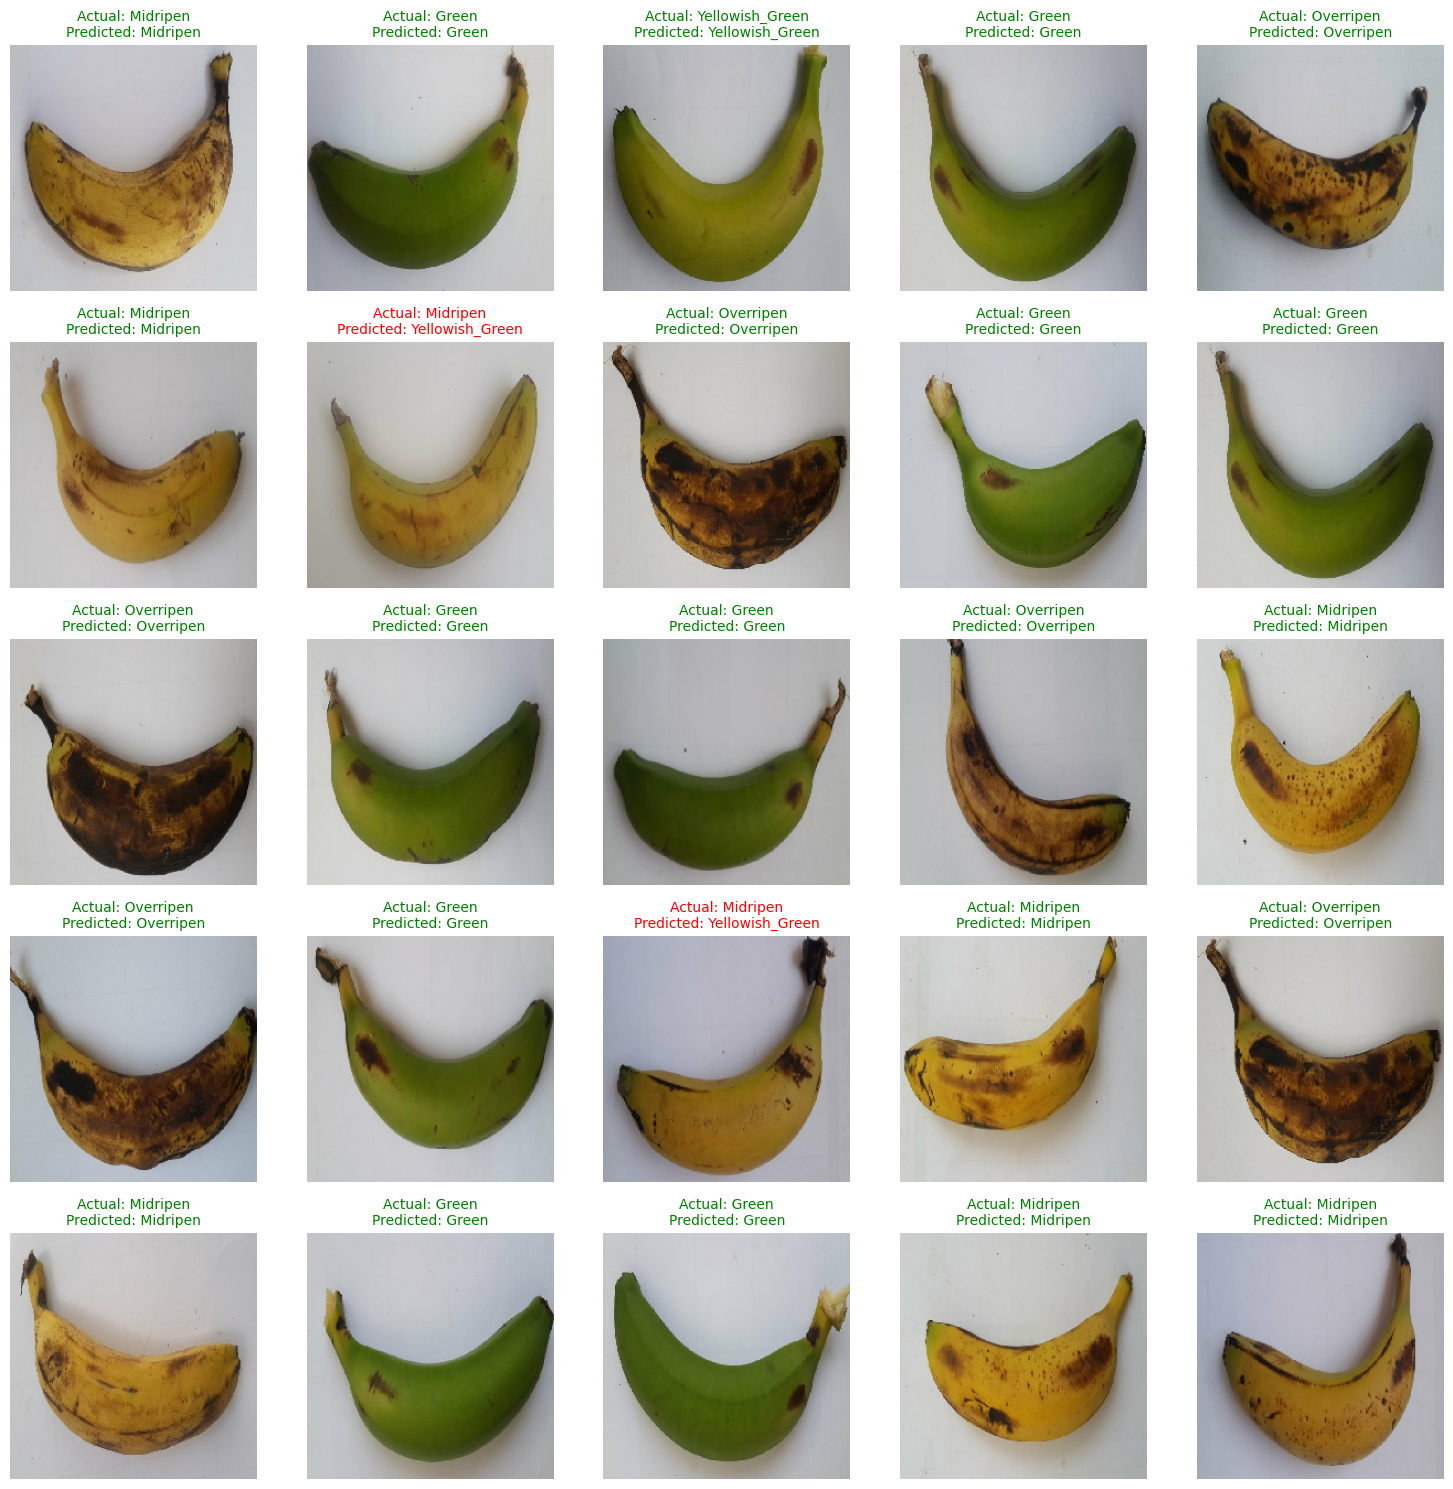

In [7]:
import numpy as np
import matplotlib.pyplot as plt

test_samples, test_labels = next(test_generator)
predictions = model.predict(test_samples)
predicted_labels = np.argmax(predictions, axis=1)    
class_names = ['Green', 'Midripen', 'Overripen', 'Yellowish_Green']

num_samples = min(len(test_samples), 25)  
plt.figure(figsize=(15, 15))

for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_samples[i])
    plt.axis('off')
    true_label_index = np.argmax(test_labels[i])
    predicted_label_index = predicted_labels[i]
    true_label = class_names[true_label_index]
    predicted_label = class_names[predicted_label_index]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f'Actual: {true_label}\nPredicted: {predicted_label}', color=color, fontsize=10)

plt.tight_layout()
plt.show()


In [9]:
from keras.models import load_model

model_path = 'D:/Mini_Project/fruit_analyzer_app/models/banana_stages_model.h5'
model.save(model_path)
